In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [7]:
url = '/content/drive/MyDrive/soft/'

In [10]:
dataset_2 = url + 'dataset_2_image.zip'
with ZipFile(dataset_2, 'r') as zip:
 zip.extractall()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
PATH = '/content/'
train_data_labels = pd.read_csv('/content/csv/updatetrain.csv', usecols = ['filename', 'digit'])
test_data_labels = pd.read_csv('/content/csv/updatetest.csv', usecols = ['filename', 'digit'])
train_data_labels.head()

,filename,digit
0,0.jpg,9
1,1.jpg,0
2,2.jpg,0
3,3.jpg,3
4,4.jpg,0


In [13]:
TRAIN_PATH = url + 'Train3'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('train')

In [14]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [16]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train_data_labels, '/content/train', train_transform)
test_data = Dataset(test_data_labels, '/content/test_28', test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  60000


# **Base Parameters**

In [17]:
batch_size = 70
num_iters = 15000
input_dim = 28*28
num_hidden = 260
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

17


In [23]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:686
Test dataloader:172


In [31]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 =nn.ReLU()

 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5=nn.ReLU()

 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 =nn.ReLU()

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [26]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=260, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=260, out_features=260, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=260, out_features=260, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=260, out_features=260, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=260, out_features=260, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=260, out_features=260, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=260, out_features=10, bias=True)
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [28]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.2999024391174316. Accuracy: 9.783333333333333
Epoch:  2
Iteration: 1000. Loss: 2.29179048538208. Accuracy: 21.5
Epoch:  3
Iteration: 1500. Loss: 2.2323684692382812. Accuracy: 33.791666666666664
Iteration: 2000. Loss: 1.5825766324996948. Accuracy: 37.916666666666664
Epoch:  4
Iteration: 2500. Loss: 0.919098973274231. Accuracy: 63.65
Epoch:  5
Iteration: 3000. Loss: 0.7420859932899475. Accuracy: 71.44166666666666
Epoch:  6
Iteration: 3500. Loss: 0.8237424492835999. Accuracy: 73.1
Iteration: 4000. Loss: 0.7835497856140137. Accuracy: 75.26666666666667
Epoch:  7
Iteration: 4500. Loss: 0.39825868606567383. Accuracy: 78.69166666666666
Epoch:  8
Iteration: 5000. Loss: 0.5739169716835022. Accuracy: 80.425
Epoch:  9
Iteration: 5500. Loss: 0.5055674314498901. Accuracy: 81.10833333333333
Iteration: 6000. Loss: 0.536465585231781. Accuracy: 81.14166666666667
Epoch:  10
Iteration: 6500. Loss: 0.7078568339347839. Accuracy: 76.31666666666666
Epoch:  11
Iteration: 7000.

In [29]:
torch.save(model.state_dict(), '/content/drive/MyDrive/soft/model_base.pkl')

[2.2999024391174316, 2.29179048538208, 2.2323684692382812, 1.5825766324996948, 0.919098973274231, 0.7420859932899475, 0.8237424492835999, 0.7835497856140137, 0.39825868606567383, 0.5739169716835022, 0.5055674314498901, 0.536465585231781, 0.7078568339347839, 0.5904392004013062, 0.3905212879180908, 0.47524937987327576, 0.4728699326515198, 0.41615986824035645, 0.41405829787254333, 0.3816720247268677, 0.29518067836761475, 0.20216578245162964, 0.40372517704963684]


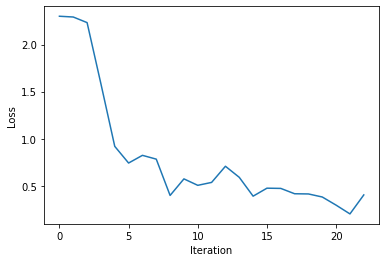

In [30]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()